# Classification Project

In [1]:
# pip install google_play_scraper #done 
# pip install app_store_scraper
# pip install deep_translator

In [2]:
###imports###
#script
from app_store_scraper import AppStore
from google_play_scraper import Sort, reviews_all, app
#EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
from langdetect import detect
from deep_translator import GoogleTranslator, PonsTranslator, LingueeTranslator
#ML 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,fbeta_score,precision_recall_curve,roc_auc_score

# Functions

In [3]:
## Function to translate and drop emoji 
def detect_and_translate(text,target_lang):#target_lang
    emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002500-\U00002BEF"  # chinese char
                        u"\U00002702-\U000027B0"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U00010000-\U0010ffff"
                        u"\u2640-\u2642" 
                        u"\u2600-\u2B55"
                        u"\u200d"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"  # dingbats
                        u"\u3030"
                           "]+", flags=re.UNICODE)
    text=emoji_pattern.sub(r' ', text)
    result_lang = text.isascii()
    if result_lang == True :
        return text  
    else :
        translate_text=GoogleTranslator(source='auto', target='en').translate(text=text)   
        return translate_text 

In [4]:
GoogleTranslator(source='auto', target='en').translate(text="فهد fahad") #check the translation

'fahad fahad'

### Scraping reviews from Tawakkalna app in Apple Store

In [5]:
# TWK_app = AppStore(country="sa", app_name="Tawakkalna (Covid-19 KSA)")
# TWK_app

* Convert to DataFrame and drop columns are not required

In [6]:
# apple_df = pd.DataFrame(np.array(TWK_app.reviews),columns=['review'])
# apple_df = apple_df.join(pd.DataFrame(apple_df.pop('review').tolist()))
# apple_df.drop(columns=['developerResponse','isEdited'],inplace=True)

* drop to concat title and review

In [7]:
# review_df=apple_df.drop(columns="title")
# title_df=apple_df.drop(columns="review")

In [8]:
# title_df.rename(columns={'title': 'review',}, inplace=True)

In [9]:
# apple_df = pd.concat([title_df,review_df ], axis=0,ignore_index=True)

* save as csv 

In [10]:
# apple_df.to_csv("apple_df.csv",index=False)

In [11]:
apple_df=pd.read_csv("Data/apple_df.csv")
apple_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6097 entries, 0 to 6096
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   rating    6097 non-null   int64 
 1   review    5919 non-null   object
 2   date      6097 non-null   object
 3   userName  6097 non-null   object
dtypes: int64(1), object(3)
memory usage: 190.7+ KB


# Data cleaning 

In [12]:
detect_and_translate("فهد Fahad 👎🏾",target_lang='en')

'Fahad Fahad'

In [13]:
apple_df.drop_duplicates(inplace=True)
print(apple_df.duplicated().sum())

# drop null rows
apple_df.dropna(inplace=True)

0


In [14]:
apple_df=apple_df[apple_df['review']!='٠']
apple_df

,rating,review,date,userName
0,4,suggestion,2021-02-05 10:14:14,r980831
1,1,location privacy offline suppprt,2021-08-08 21:11:24,sweatytryhard989
2,5,removal auto selection pfizer approval vaccina...,2021-08-09 10:48:24,Lei Davinci
3,4,good overall,2020-05-07 11:41:27,hadkamal
4,5,login log,2021-09-09 17:56:20,ebuHuda
...,...,...,...,...
6092,1,keeps giving error show jailbreak device total...,2020-05-30 20:10:36,omar.5472
6093,1,poor application trying login hour sends messa...,2020-05-25 11:12:16,ahsan743
6094,5,not able sign trying shows exempted employees ...,2020-05-13 23:44:24,ahadsatelite
6095,5,may god bless leadership help guide direct mis...,2021-03-25 02:56:07,علي الوقيص


In [15]:
#Removing numbers to translate text
def rem_num(phrase):
#     print(phrase)
    return re.sub("\S*\d\S*", "", phrase).strip().replace('  ', ' ')
apple_df.review = apple_df.review.apply(rem_num)


In [16]:
apple_df = apple_df[apple_df.review != '']

In [17]:
def decontracted(phrase):
    # specific
    
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
apple_df.review = apple_df.review.apply(decontracted)

#Removing numbers
def rem_num(phrase):
    return re.sub("\S*\d\S*", "", phrase).strip().replace('  ', ' ')
apple_df.review = apple_df.review.apply(rem_num)

# #Removing spacial character
def rem_char(phrase):
    return re.sub('[^A-Za-z]+', ' ', phrase).strip().replace('  ', ' ')
apple_df.review = apple_df.review.apply(rem_char)

#Removing html tags
def rem_html(phrase):
    return re.sub('[^A-Za-z]+', ' ', phrase)
apple_df.review =  apple_df.review.apply(rem_html)

apple_df.review.head()

0                                           suggestion
1                     location privacy offline suppprt
2    removal auto selection pfizer approval vaccina...
3                                         good overall
4                                            login log
Name: review, dtype: object

### Translate

In [18]:
# newcol=[]
# for i in apple_df.review:
#     newcol.append(detect_and_translate(i,target_lang='en'))

In [19]:
# apple_df["review"]=newcol

*

In [20]:
#removing stop words
stopwords= set([
    'br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're",
    "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
    'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they',
    'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
    "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have',
    'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',
    'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
    'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't',
    'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
    've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't",
    'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
    "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
    ])
def rem_stopwords(phrase):
    return ' '.join(e.lower() for e in phrase.split() if e.lower() not in stopwords)
apple_df.review = apple_df.review.apply(rem_stopwords)

<AxesSubplot:xlabel='rating', ylabel='Count'>

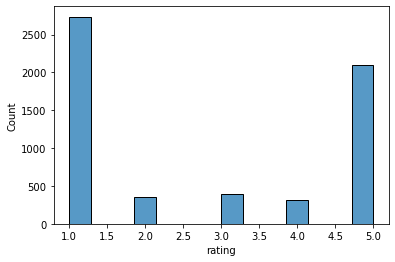

In [21]:
sns.histplot(apple_df["rating"])

# Scraping reviews from Tawakkalna app in Google Store

In [22]:
# google_df = pd.DataFrame(np.array(google_reviews),columns=['review'])
# google_df = google_df.join(pd.DataFrame(google_df.pop('review').tolist()))

In [23]:
# google_df.content.dropna(inplace=True)
# print(google_df.dropna().sum())

# # drop null rows
# google_df.dropna(inplace=True)
# #Exclude empty reviews
# google_df = google_df[google_df.content != '']

In [24]:
# google_df.drop(columns=['content','thumbsUpCount',"reviewCreatedVersion"],inplace=True)

In [25]:
# google_df.drop(columns=["reviewId","userImage",'replyContent','repliedAt'],inplace=True)

In [26]:
# google_df.rename(columns={'at': 'date','score':'rating'}, inplace=True)

## Translate

In [27]:
# list_g=[]
# for i in google_df.content:
#         list_g.append(detect_and_translate(i,target_lang='en'))

In [28]:
# google_df["review"]=list_ggg

In [29]:
# google_df.drop(columns=['content','thumbsUpCount',"reviewCreatedVersion"],inplace=True)

In [30]:
# google_df.to_csv("google_df.csv",index=False)

In [31]:
google_df = pd.read_csv("Data/google_df.csv")
google_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36158 entries, 0 to 36157
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  36158 non-null  object
 1   rating    36158 non-null  int64 
 2   date      36158 non-null  object
 3   review    36158 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


# concatttttt

In [32]:
# Data_df = pd.concat([apple_df,google_df ], axis=0,ignore_index=True)

In [33]:
# Data_df.dropna()

In [34]:
# ## to convert all review to string if any not string
# for i in range(0,len(Data_df)-1):
#     if type(Data_df.iloc[i]['review']) != str:
#         Data_df.iloc[i]['review'] = str(Data_df.iloc[i]['review']) 

In [35]:
Data_df =pd.read_csv('Data/Data_df.csv')

In [36]:
Data_df.dropna(inplace=True)

In [37]:
def decontracted(phrase):
    # specific
    
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
Data_df.review = Data_df.review.apply(decontracted)

#Removing numbers
def rem_num(phrase):
    return re.sub("\S*\d\S*", "", phrase).strip().replace('  ', ' ')
Data_df.review = Data_df.review.apply(rem_num)

#Removing spacial character
def rem_char(phrase):
    return re.sub('[^A-Za-z]+', ' ', phrase).strip().replace('  ', ' ')
Data_df.review = Data_df.review.apply(rem_char)

#Removing html tags
def rem_html(phrase):
    return re.sub('[^A-Za-z]+', ' ', phrase)
Data_df.review =  Data_df.review.apply(rem_html)

Data_df

,rating,review,date,userName,sentiment,all_features
0,4,suggestion,2021-02-05 10:14:14,r980831,1,r980831 suggestion
1,1,location privacy offline suppprt,2021-08-08 21:11:24,sweatytryhard989,0,sweatytryhard989 location privacy offline suppprt
2,5,removal auto selection pfizer approval vaccina...,2021-08-09 10:48:24,Lei Davinci,1,Lei Davinci removal auto selection pfizer appr...
3,4,good overall,2020-05-07 11:41:27,hadkamal,1,hadkamal good overall
4,5,login log,2021-09-09 17:56:20,ebuHuda,1,ebuHuda login log
...,...,...,...,...,...,...
40355,2,Not working I can not register and I received ...,2020-04-12 12:33:41,Ramy Mohamed,0,Ramy Mohamed Not working I can not register an...
40356,1,The program does not work with my device Samsu...,2020-04-11 14:26:39,Ismael Khan,0,Ismael Khan The program does not work with my ...
40357,1,I can not even register Keeps saying something...,2020-04-11 00:18:07,Ali Khalid,0,Ali Khalid I can not even register Keeps sayin...
40358,5,Excellent and may God grant you success but wh...,2020-04-09 17:56:37,Abdullateef Addajani,1,Abdullateef Addajani Excellent and may God gra...


In [38]:
def rem_stopwords(phrase):
    return ' '.join(e.lower() for e in phrase.split() if e.lower() not in stopwords)
Data_df.review = Data_df.review.apply(rem_stopwords)

In [39]:
Data_df.date = pd.to_datetime(Data_df['date'], format='%Y-%m-%d %H:%M:%S.%f')

In [40]:
Data_df.sort_values(by='date',inplace=True)

In [41]:
Data_df

,rating,review,date,userName,sentiment,all_features
120,5,effective solution,2020-04-07 00:37:23,Mohamed Albitar,1,Mohamed Albitar effective solution
3012,5,super user friendly thank effective solution,2020-04-07 00:37:23,Mohamed Albitar,1,Mohamed Albitar super user friendly thank effe...
5628,1,cannot log create new account enter absher acc...,2020-04-07 03:34:24,majeed..,0,majeed.. cannot log create new account enter a...
2816,1,app not working,2020-04-07 03:34:24,majeed..,0,majeed.. app not working
2815,1,not register,2020-04-07 06:56:22,محمود مروان,0,محمود مروان not register
...,...,...,...,...,...,...
3697,1,application whole closed closed entered exit r...,2021-10-01 23:52:28,Rawan__c,0,Rawan__c application whole closed closed enter...
811,5,speak arabic,2021-10-02 04:13:28,ديمووون,1,ديمووون speak arabic
3686,5,premise english comments wrong program not,2021-10-02 04:13:28,ديمووون,1,ديمووون premise english comments wrong program...
2891,1,consumes battery,2021-10-02 12:24:04,Abdulaziz@91,0,Abdulaziz@91 consumes battery


In [42]:
# Data_df = Data_df[Data_df['rating'] != 3]
# Data_df

In [43]:
def sentiment(n):
    return 0 if n >= 4 else 1
Data_df['sentiment'] = Data_df['rating'].apply(sentiment)
Data_df.head()

,rating,review,date,userName,sentiment,all_features
120,5,effective solution,2020-04-07 00:37:23,Mohamed Albitar,0,Mohamed Albitar effective solution
3012,5,super user friendly thank effective solution,2020-04-07 00:37:23,Mohamed Albitar,0,Mohamed Albitar super user friendly thank effe...
5628,1,cannot log create new account enter absher acc...,2020-04-07 03:34:24,majeed..,1,majeed.. cannot log create new account enter a...
2816,1,app not working,2020-04-07 03:34:24,majeed..,1,majeed.. app not working
2815,1,not register,2020-04-07 06:56:22,محمود مروان,1,محمود مروان not register


In [44]:
#Data_df.to_csv("Data_df.csv",index=False)

In [45]:
# Data_df =pd.read_csv('Data/Data_df.csv')

In [46]:
Data_df.sentiment.value_counts()

0    28916
1    11271
Name: sentiment, dtype: int64

In [47]:
Data_df1=Data_df.copy()

C:\Users\Fahad-MSi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


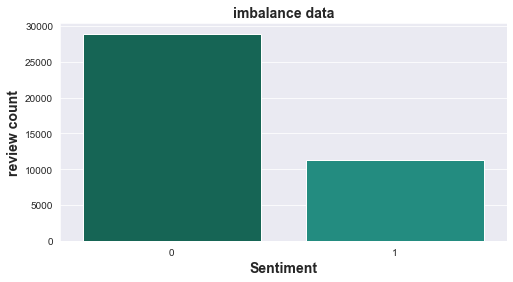

In [146]:
#2. distribution of target variable.
plt.figure(figsize = [8,4])
sns.countplot(Data_df1['sentiment'],palette=['#09725D',"#119E8E"])

# Add labels

plt.title('imbalance data', fontsize = 14, weight = 'bold')
plt.xlabel('Sentiment', fontsize = 14, weight = 'bold')
plt.ylabel('review count', fontsize = 14, weight = 'bold')
sns.set_style("darkgrid")

In [49]:
Data_df.sentiment[Data_df.sentiment == 0 ] = Data_df.sentiment[Data_df.sentiment == 0 ].iloc[:len(Data_df.sentiment[(Data_df.sentiment == 1)])]

<ipython-input-49-1d1f2eee9eef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_df.sentiment[Data_df.sentiment == 0 ] = Data_df.sentiment[Data_df.sentiment == 0 ].iloc[:len(Data_df.sentiment[(Data_df.sentiment == 1)])]


In [50]:
Data_df.dropna(inplace=True)

In [51]:
Data_df.sentiment.value_counts()

0.0    11271
1.0    11271
Name: sentiment, dtype: int64

In [52]:
Data_df.reset_index(inplace=True)

C:\Users\Fahad-MSi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


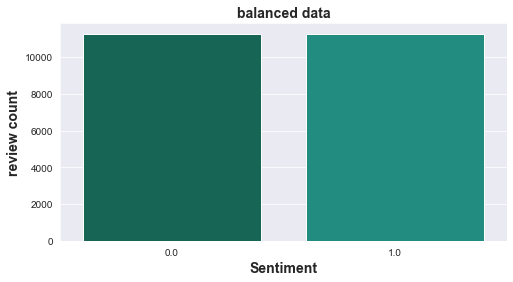

In [148]:
#2. distribution of target variable.
plt.figure(figsize = [8,4])
sns.countplot(Data_df['sentiment'],palette=['#09725D',"#119E8E"])


# Add labels
plt.title('balanced data', fontsize = 14, weight = 'bold')
plt.xlabel('Sentiment', fontsize = 14, weight = 'bold')
plt.ylabel('review count', fontsize = 14, weight = 'bold')


# model

In [135]:
X = Data_df['review']
y = Data_df['sentiment']

In [136]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=45)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,random_state=45)

In [137]:
##frequency for word
cv = CountVectorizer(stop_words='english')
X_train_T = cv.fit_transform(X_train)
X_val_T = cv.transform(X_val)
X_test_T = cv.transform(X_test)

In [138]:
lr = LogisticRegression()
lr.fit(X_train_T, y_train)

LogisticRegression()

In [140]:
# LogisticRegression #Accuracy
print("Accuracy Train = {:6.5f}".format(accuracy_score(y_train, lr.predict(X_train_T))))
print("Accuracy Val = {:6.5f}".format(accuracy_score(y_val, lr.predict(X_val_T))))
print("Accuracy Test = {:6.5f}".format(accuracy_score(y_test, lr.predict(X_test_T))))

print("-------------------------")
# LogisticRegression F1
print("F1 Train = {:6.5f}".format(f1_score(y_train, lr.predict(X_train_T))))
print("F1 Val = {:6.5f}".format(f1_score(y_val, lr.predict(X_val_T))))
print("F1 Test = {:6.5f}".format(f1_score(y_test, lr.predict(X_test_T))))
print("-------------------------")
# LogisticRegression recall
print("recall Train = {:6.5f}".format(recall_score(y_train, lr.predict(X_train_T))))
print("recall Val = {:6.5f}".format(recall_score(y_val, lr.predict(X_val_T))))
print("recall Test = {:6.5f}".format(recall_score(y_test, lr.predict(X_test_T))))
print("-------------------------")
# LogisticRegression precision
print("precision Train = {:6.5f}".format(precision_score(y_train, lr.predict(X_train_T))))
print("precision Val = {:6.5f}".format(precision_score(y_val, lr.predict(X_val_T))))
print("precision Test = {:6.5f}".format(precision_score(y_test, lr.predict(X_test_T))))
print("-------------------------")
# LogisticRegression f2
print("F2 Train = {:6.5f}".format(fbeta_score(y_train, lr.predict(X_train_T),beta=2)))
print("F2 Val = {:6.5f}".format(fbeta_score(y_val, lr.predict(X_val_T),beta=2)))
print("F2 Test = {:6.5f}".format(fbeta_score(y_test, lr.predict(X_test_T),beta=2)))

Accuracy Train = 0.90195
Accuracy Val = 0.84254
Accuracy Test = 0.83832
-------------------------
F1 Train = 0.89944
F1 Val = 0.83908
F1 Test = 0.84217
-------------------------
recall Train = 0.87930
recall Val = 0.83266
recall Test = 0.84418
-------------------------
precision Train = 0.92052
precision Val = 0.84559
precision Test = 0.84017
-------------------------
F2 Train = 0.88725
F2 Val = 0.83521
F2 Test = 0.84338


In [59]:
#test the text
df_pred = pd.Series('good')
df_pred = cv.transform(df_pred)
int(lr.predict(df_pred))

0

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer

In [61]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(X_train_T)

TfidfTransformer()

In [62]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])  
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
good,2.501272
app,2.719946
application,3.683583
working,3.734649
nice,3.807881
...,...
electric,9.819148
elec,9.819148
orang,9.819148
ops,9.819148


In [63]:
count_vector=cv.transform(X_train) 
 # tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [64]:
feature_names = cv.get_feature_names() 
 #get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 #print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
good,1.0
aa,0.0
prophet,0.0
properly,0.0
proper,0.0
...,...
fun,0.0
fully,0.0
fullest,0.0
fulfilled,0.0


In [65]:
df.reset_index(level=0, inplace=True)

In [66]:
df.tfidf

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5656    0.0
5657    0.0
5658    0.0
5659    0.0
5660    0.0
Name: tfidf, Length: 5661, dtype: float64

In [67]:
df.rename(columns={'index': 'word',}, inplace=True)

In [68]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(df['word'], df['tfidf'], test_size=0.2,random_state=45)
X_train_tf, X_val_tf, y_train_tf, y_val_tf = train_test_split(X_train_tf, y_train_tf, test_size=0.25,random_state=45)

In [69]:
cv_tf = CountVectorizer()
X_train_Tf1 = cv.fit_transform(X_train_tf)
X_val_Tf1 = cv.transform(X_val_tf)
X_test_Tf1 = cv.transform(X_test_tf)

In [70]:
y_train_tf

3200    0.0
2852    0.0
530     0.0
3505    0.0
3049    0.0
       ... 
2892    0.0
377     0.0
412     0.0
4907    0.0
202     0.0
Name: tfidf, Length: 3396, dtype: float64

In [71]:
df.tfidf

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5656    0.0
5657    0.0
5658    0.0
5659    0.0
5660    0.0
Name: tfidf, Length: 5661, dtype: float64

In [72]:
X_train_Tf1

<3396x3396 sparse matrix of type '<class 'numpy.int64'>'
	with 3396 stored elements in Compressed Sparse Row format>

In [73]:
# lr.fit(X_train_Tf1, y_train)

In [74]:
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [142]:
rf = RandomForestClassifier(n_estimators=400,max)
rf.fit(X_train_T,y_train)

RandomForestClassifier(n_estimators=400)

In [143]:
accuracy_score(y_train,rf.predict(X_train_T))

0.9392191659272404

In [144]:
# LogisticRegression #Accuracy
print("Accuracy Train = {:6.5f}".format(accuracy_score(y_train, rf.predict(X_train_T))))
print("Accuracy Val = {:6.5f}".format(accuracy_score(y_val, rf.predict(X_val_T))))
print("Accuracy Test = {:6.5f}".format(accuracy_score(y_test, rf.predict(X_test_T))))

print("-------------------------")
# LogisticRegression F1
print("F1 Train = {:6.5f}".format(f1_score(y_train, rf.predict(X_train_T))))
print("F1 Val = {:6.5f}".format(f1_score(y_val, rf.predict(X_val_T))))
print("F1 Test = {:6.5f}".format(f1_score(y_test, rf.predict(X_test_T))))
print("-------------------------")
print("recall Train = {:6.5f}".format(recall_score(y_train, rf.predict(X_train_T))))
print("recall Val = {:6.5f}".format(recall_score(y_val, rf.predict(X_val_T))))
print("recall Test = {:6.5f}".format(recall_score(y_test, rf.predict(X_test_T))))
print("-------------------------")
print("precision Train = {:6.5f}".format(precision_score(y_train, rf.predict(X_train_T))))
print("precision Val = {:6.5f}".format(precision_score(y_val, rf.predict(X_val_T))))
print("precision Test = {:6.5f}".format(precision_score(y_test, rf.predict(X_test_T))))
print("-------------------------")
print("f2 Train = {:6.5f}".format(fbeta_score(y_train, rf.predict(X_train_T),beta=2)))
print("f2 Val = {:6.5f}".format(fbeta_score(y_val, rf.predict(X_val_T),beta=2)))
print("f2 Test = {:6.5f}".format(fbeta_score(y_test, rf.predict(X_test_T),beta=2)))

Accuracy Train = 0.93922
Accuracy Val = 0.84165
Accuracy Test = 0.83566
-------------------------
F1 Train = 0.93667
F1 Val = 0.83048
F1 Test = 0.83132
-------------------------
recall Train = 0.90139
recall Val = 0.78677
recall Test = 0.79253
-------------------------
precision Train = 0.97482
precision Val = 0.87934
precision Test = 0.87410
-------------------------
f2 Train = 0.91518
f2 Val = 0.80369
f2 Test = 0.80761


In [151]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, rf.predict(X_test_T))
cnf_matrix

array([[1942,  263],
       [ 478, 1826]], dtype=int64)

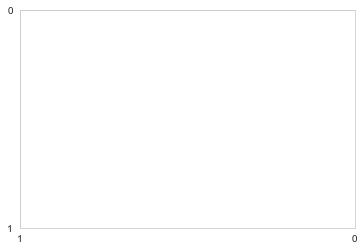

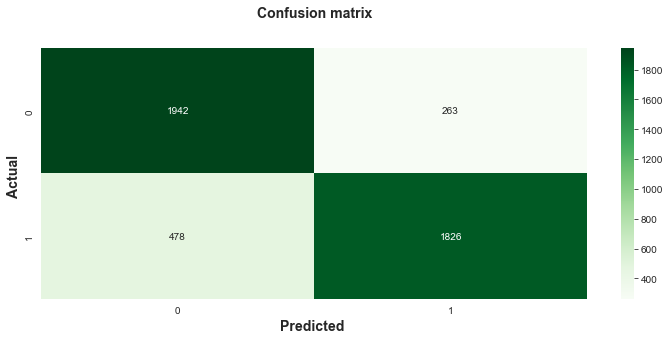

In [153]:
class_names=[1,0] # name  of classes
# fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
######## create heatmap
plt.figure(figsize = [10,4])
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='Greens' ,fmt='g')
# ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', fontsize = 14, weight = 'bold',y=1.1)
plt.ylabel('Actual ',fontsize = 14, weight = 'bold')
plt.xlabel('Predicted ',fontsize = 14, weight = 'bold')
sns.set_style("whitegrid")



auc_train = 0.96475
auc_val =0.89738
auc_test = 0.89264


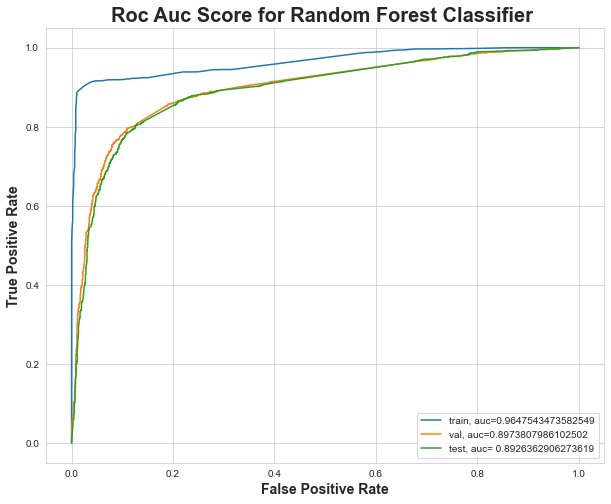

In [164]:
plt.figure(figsize = [10,8])
y_pred_proba = rf.predict_proba(X_train_T)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_proba)
auc = metrics.roc_auc_score(y_train, y_pred_proba)
print("auc_train = {:6.5f}".format(auc))
plt.plot(fpr,tpr,label="train, auc="+str(auc))
plt.legend(loc=4)


y_pred_proba_val = rf.predict_proba(X_val_T)[::,1]
fpr_val, tpr_val, _val = metrics.roc_curve(y_val,  y_pred_proba_val)
auc_val = metrics.roc_auc_score(y_val, y_pred_proba_val)
print("auc_val ={:6.5f}".format(auc_val))
plt.plot(fpr_val,tpr_val,label="val, auc="+str(auc_val))
plt.legend(loc=4)


y_pred_proba_test = rf.predict_proba(X_test_T)[::,1]
fpr_test, tpr_test, _test = metrics.roc_curve(y_test,  y_pred_proba_test)
auc_test = metrics.roc_auc_score(y_test, y_pred_proba_test)
print("auc_test = {:6.5f}".format(auc_test))
plt.plot(fpr_test,tpr_test,label="test, auc= "+str(auc_test))
plt.legend(loc=4)

plt.title('Roc Auc Score for Random Forest Classifier ', fontsize = 20, weight = 'bold')
plt.xlabel('False Positive Rate',fontsize = 14, weight = 'bold')
plt.ylabel('True Positive Rate', fontsize = 14, weight = 'bold')
sns.set_style("whitegrid")



In [81]:
print("Accuracy:",metrics.accuracy_score(y_test, rf.predict(X_test_T)))
print("Precision:",metrics.precision_score(y_test, rf.predict(X_test_T)))
print("Recall:",metrics.recall_score(y_test, rf.predict(X_test_T)))

Accuracy: 0.8369926813040586
Precision: 0.8748208313425705
Recall: 0.7947048611111112


In [82]:
from sklearn.neighbors import KNeighborsClassifier

In [83]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_T, y_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train_T, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test_T, y_test)))

The score for kNN is
Training:  84.38%
Test set:  80.62%


In [84]:
from sklearn.metrics import confusion_matrix

In [85]:
print("kNN confusion matrix: \n\n", confusion_matrix(y_test, knn.predict(X_test_T)))

kNN confusion matrix: 

 [[1852  353]
 [ 521 1783]]


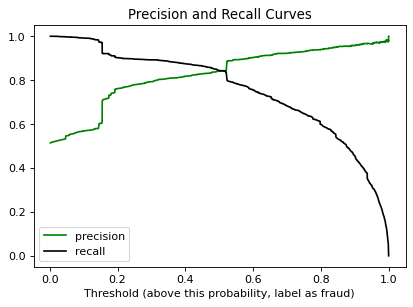

In [86]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lr.predict_proba(X_test_T)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],c='green',label='precision')
plt.plot(threshold_curve, recall_curve[1:],c='black', label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

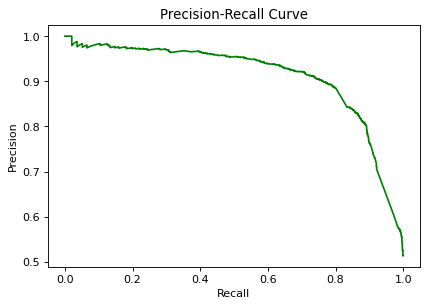

In [87]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],c='green',label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

ROC AUC score =  0.9052795886873268


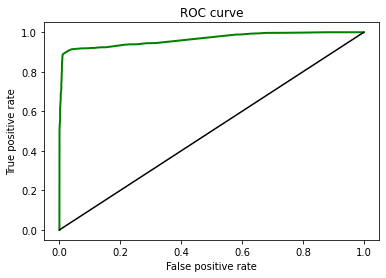

In [88]:
plt.plot(fpr, tpr,c="green",lw=2)
plt.plot([0,1],[0,1],c='black',ls='-')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, lr.predict_proba(X_test_T)[:,1]))

In [89]:
# xgb.plot_importance(gbm)
# xgb.plot_importance(gbm, importance_type='gain')

In [90]:
# gbm.get_booster().get_score(importance_type='weight')

In [91]:
# gbm.get_booster().get_score(importance_type='gain')

In [92]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train_T,y_train),(X_val_T,y_val)]
fit_model = gbm.fit( 
                    X_train_T, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

# accuracy_score(y_test, gbm.predict(X_test_T, ntree_limit=gbm.best_ntree_limit)) 

C:\Users\Fahad-MSi\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [93]:
print("XGB Accuracy Train = ",accuracy_score(y_train, gbm.predict(X_train_T, ntree_limit=gbm.best_ntree_limit)))
print("XGB Accuracy Val = ",accuracy_score(y_val, gbm.predict(X_val_T, ntree_limit=gbm.best_ntree_limit))) 
print("XGB Accuracy Test = ",accuracy_score(y_test, gbm.predict(X_test_T, ntree_limit=gbm.best_ntree_limit))) 
print("----------------------")
print("XGB F1 Train = ",f1_score(y_train, gbm.predict(X_train_T, ntree_limit=gbm.best_ntree_limit)))
print("XGB F1 Val = ",f1_score(y_val, gbm.predict(X_val_T, ntree_limit=gbm.best_ntree_limit))) 
print("XGB F1 Test = ",f1_score(y_test, gbm.predict(X_test_T, ntree_limit=gbm.best_ntree_limit))) 

C:\Users\Fahad-MSi\anaconda3\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\Fahad-MSi\anaconda3\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\Fahad-MSi\anaconda3\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\Fahad-MSi\anaconda3\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


XGB Accuracy Train =  0.8325199645075422
XGB Accuracy Val =  0.8236859614105123
XGB Accuracy Test =  0.8205810601020181
----------------------
XGB F1 Train =  0.8407285001054778
XGB F1 Val =  0.8303094983991464
XGB F1 Test =  0.8338467857876362


C:\Users\Fahad-MSi\anaconda3\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\Fahad-MSi\anaconda3\lib\site-packages\xgboost\core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
